Using climate data file: c:\Users\Chris\Downloads\AAI 551\data\export.csv
ClimateData(station_id=MY_STATION, region=My Region, n_days=4018, 2014-01-01–2024-12-31)


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2014-01-01,-2.212500,-5.562500,1.137500,0.0,0.0,260.0,12.254167,NaN,1027.212500,NaN
1,2014-01-02,-1.795833,-4.595833,1.004167,0.0,0.0,30.0,20.779167,NaN,1019.293750,NaN
2,2014-01-03,-9.070833,-11.820833,-6.320833,12.3,0.0,360.0,28.070833,NaN,1013.010417,NaN
3,2014-01-04,-10.425000,-15.425000,-5.425000,0.0,0.0,200.0,11.275000,NaN,1031.662500,NaN
4,2014-01-05,-3.929167,-8.579167,0.720833,3.8,0.0,0.0,3.658333,NaN,1025.081250,NaN


Weekly dataset has 583 rows and 12 columns.


,year,week,week_start,tavg_mean,diurnal_range_mean,prcp_total,prcp_mean,rainy_day_count,temp_change_rate,cold_day_count,n_days,dry_fraction
0,2014,1,2013-12-30,-5.486667,7.420000,16.1,3.220000,2,NaN,5,5,0.600000
1,2014,1,2014-12-29,1.251389,5.366667,0.0,0.000000,0,6.738056,3,3,1.000000
2,2014,2,2014-01-06,-0.354762,10.100000,26.6,3.800000,4,-1.606151,7,7,0.428571
3,2014,3,2014-01-13,3.779762,6.085714,10.9,1.557143,2,4.134524,6,7,0.714286
4,2014,4,2014-01-20,-6.501786,7.771429,11.2,1.600000,4,-10.281548,7,7,0.428571


Missing required columns: None


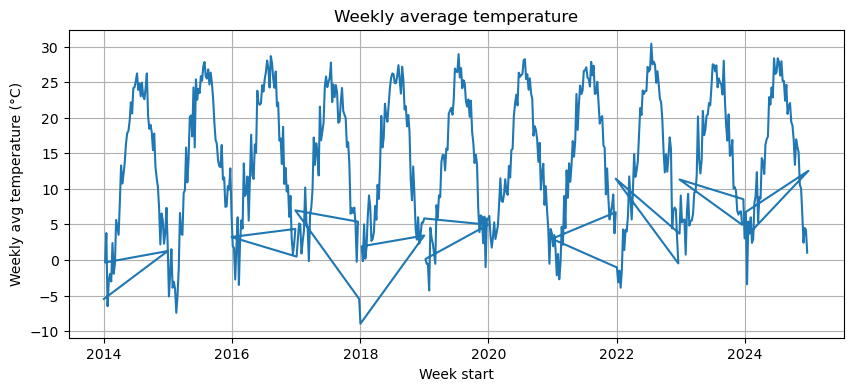

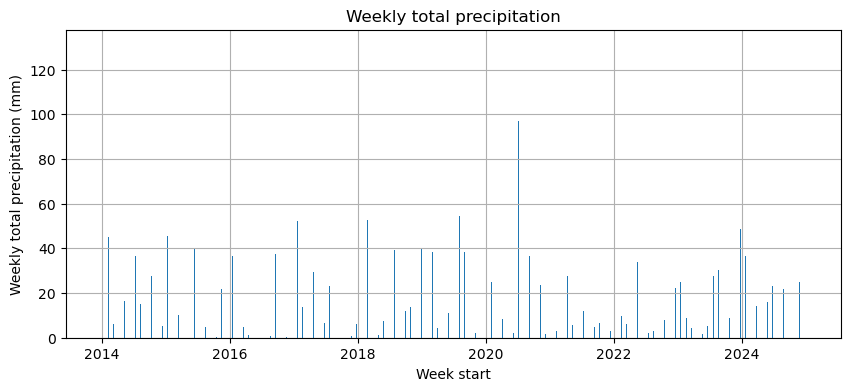

Trend-based peak label distribution:
0    0.981132
1    0.018868
Name: is_peak, dtype: float64


,week_start,tavg_mean,cold_day_count,prcp_total,is_peak
0,2013-12-30,-5.486667,5,16.1,0
1,2014-12-29,1.251389,3,0.0,0
2,2014-01-06,-0.354762,7,26.6,0
3,2014-01-13,3.779762,6,10.9,0
4,2014-01-20,-6.501786,7,11.2,0


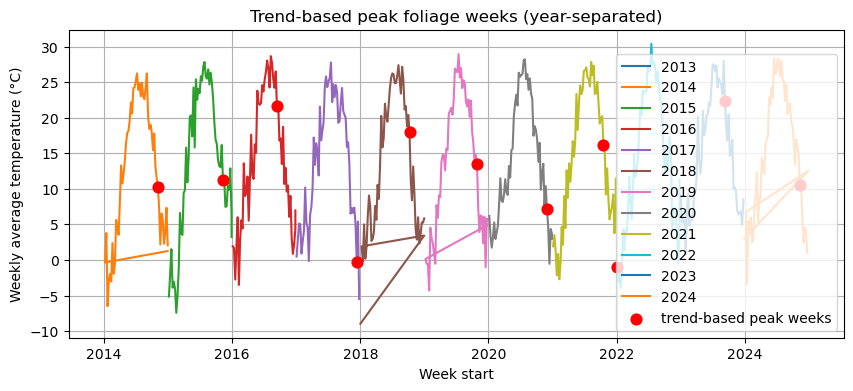

Number of usable weeks for LSTM training: 582


,week_start,is_peak,tavg_mean,diurnal_range_mean,temp_change_rate,cold_day_count,prcp_total,dry_fraction
0,2014-12-29,0,1.251389,5.366667,6.738056,3,0.0,1.000000
1,2014-01-06,0,-0.354762,10.100000,-1.606151,7,26.6,0.428571
2,2014-01-13,0,3.779762,6.085714,4.134524,6,10.9,0.714286
3,2014-01-20,0,-6.501786,7.771429,-10.281548,7,11.2,0.428571
4,2014-01-27,0,-2.910119,9.114286,3.591667,7,1.4,0.857143


LSTM validation metrics: {'accuracy': 0.9770114942528736, 'f1': 0.0, 'roc_auc': 0.8808823529411764}
Validation metrics: {'accuracy': 0.9770114942528736, 'f1': 0.0, 'roc_auc': 0.8808823529411764}


,week_start,is_peak,peak_prob_lstm
0,2014-12-29,0,NaN
1,2014-01-06,0,NaN
2,2014-01-13,0,NaN
3,2014-01-20,0,0.032540
4,2014-01-27,0,0.017262


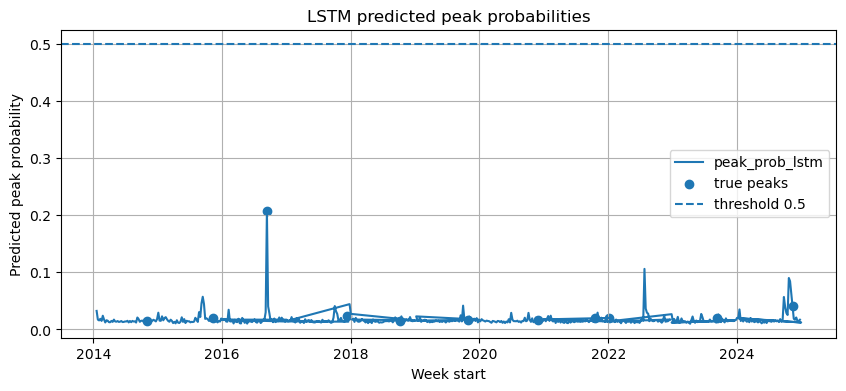

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from maple.climate_data import ClimateData, InvalidClimateDataError
from maple.features import WeeklyClimateDataset
from maple.labels import assign_peak_labels_trend_based
from maple.lstm import FoliageLSTMModel
from maple.utils import ensure_file_exists

plt.rcParams["figure.figsize"] = (10, 4)

# === Project paths ===
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"

CLIMATE_CSV = ensure_file_exists(DATA_DIR / "export.csv")
print("Using climate data file:", CLIMATE_CSV)

# === Load climate data ===
try:
    climate = ClimateData.from_csv(
        path=CLIMATE_CSV,
        station_id="MY_STATION",   # Not from dataset; just an identifier
        region_name="My Region",   # Not from dataset; descriptive label
    )
except FileNotFoundError as e:
    print("File not found:", e)
    raise
except InvalidClimateDataError as e:
    print("CSV column validation failed:", e)
    raise

print(climate)
display(climate.df.head())


# === Step 1: Generate weekly features ===
weekly_dataset = WeeklyClimateDataset.from_climate(climate)
weekly_df = weekly_dataset.weekly_df.copy()

print(f"Weekly dataset has {len(weekly_df)} rows and {len(weekly_df.columns)} columns.")
display(weekly_df.head())

required_cols = [
    "tavg_mean",
    "diurnal_range_mean",
    "temp_change_rate",
    "cold_day_count",
    "prcp_total",
    "dry_fraction",
]
missing = [c for c in required_cols if c not in weekly_df.columns]
print("Missing required columns:", missing if missing else "None")


# === Step 2: Basic visualizations (weekly temperature & precipitation) ===
plt.plot(weekly_df["week_start"], weekly_df["tavg_mean"])
plt.xlabel("Week start")
plt.ylabel("Weekly avg temperature (°C)")
plt.title("Weekly average temperature")
plt.grid(True)
plt.show()

plt.bar(weekly_df["week_start"], weekly_df["prcp_total"])
plt.xlabel("Week start")
plt.ylabel("Weekly total precipitation (mm)")
plt.title("Weekly total precipitation")
plt.grid(True)
plt.show()


# === Step 3: Trend-based labeling (1 peak per year) ===
labeled_df = assign_peak_labels_trend_based(
    weekly_df,
    smooth_window=3,
    offset=1,
)

print("Trend-based peak label distribution:")
print(labeled_df["is_peak"].value_counts(normalize=True))

display(
    labeled_df[
        ["week_start", "tavg_mean", "cold_day_count", "prcp_total", "is_peak"]
    ].head()
)

# Plot per year to avoid jump lines
for year, df_y in labeled_df.groupby(labeled_df["week_start"].dt.year):
    plt.plot(
        df_y["week_start"],
        df_y["tavg_mean"],
        label=str(year)
    )

# Mark detected peak weeks
peak_weeks = labeled_df[labeled_df["is_peak"] == 1]
plt.scatter(
    peak_weeks["week_start"],
    peak_weeks["tavg_mean"],
    color="red",
    s=60,
    label="trend-based peak weeks",
    zorder=5
)

plt.title("Trend-based peak foliage weeks (year-separated)")
plt.xlabel("Week start")
plt.ylabel("Weekly average temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


# === Step 4: Train LSTM model ===
needed_cols = set(FoliageLSTMModel.feature_cols) | {"is_peak"}
train_df = labeled_df.dropna(subset=needed_cols).reset_index(drop=True)

print(f"Number of usable weeks for LSTM training: {len(train_df)}")
display(
    train_df[["week_start", "is_peak"] + list(FoliageLSTMModel.feature_cols)].head()
)

model = FoliageLSTMModel(
    num_epochs=20,
    hidden_dim=32,
    seq_len=4,
    batch_size=16,
)

metrics = model.fit(train_df)
print("Validation metrics:", metrics)


# === Step 5: Predict peak probabilities for all weeks ===
pred_df = model.predict(train_df)
display(pred_df[["week_start", "is_peak", "peak_prob_lstm"]].head())

plt.plot(pred_df["week_start"], pred_df["peak_prob_lstm"], label="peak_prob_lstm")
plt.scatter(
    pred_df.loc[pred_df["is_peak"] == 1, "week_start"],
    pred_df.loc[pred_df["is_peak"] == 1, "peak_prob_lstm"],
    label="true peaks",
)
plt.axhline(0.5, linestyle="--", label="threshold 0.5")
plt.xlabel("Week start")
plt.ylabel("Predicted peak probability")
plt.title("LSTM predicted peak probabilities")
plt.legend()
plt.grid(True)
plt.show()
